# Set up workspace

In [26]:
ssp126_LU1

<xarray.DataArray 'cVeg' (time: 1032, lat: 160, lon: 320)>
dask.array<mean_agg-aggregate, shape=(1032, 160, 320), dtype=float32, chunksize=(1032, 160, 320), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * lat      (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
  * lon      (lon) float64 0.0 1.125 2.25 3.375 4.5 ... 355.5 356.6 357.8 358.9

In [2]:
import sys
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs

# the eofs Python package is the main tool used in this analysis
# documentation for this Python package is available at https://ajdawson.github.io/eofs/latest/index.html
from eofs.xarray import Eof 

In [17]:
import matplotlib

In [3]:
sys.path.append('/glade/u/home/czarakas/coupled_PPE/code/analyze_simulations')

In [4]:
from load_ensembles import *
import quick_map

# Load data

In [5]:
var='TREFHT'

In [6]:
ds_ensemble = load_coupled_ensemble(var=var, domain='atm', printon=False)

/glade/u/home/czarakas/coupled_PPE/code/analyze_simulations/load_ensembles.py:46: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  ds = xr.open_mfdataset(fpath)
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


In [7]:
ds_to_analyze=ds_ensemble[0][var]

### Get area weights

#### Functions for area weights

In [8]:
def earth_radius(lat):
    '''
    calculate radius of Earth assuming oblate spheroid
    defined by WGS84
    
    Input
    ---------
    lat: vector or latitudes in degrees  
    
    Output
    ----------
    r: vector of radius in meters
    
    Notes
    -----------
    WGS84: https://earth-info.nga.mil/GandG/publications/tr8350.2/tr8350.2-a/Chapter%203.pdf
    '''
    from numpy import deg2rad, sin, cos

    # define oblate spheroid from WGS84
    a = 6378137
    b = 6356752.3142
    e2 = 1 - (b**2/a**2)
    
    # convert from geodecic to geocentric
    # see equation 3-110 in WGS84
    lat = deg2rad(lat)
    lat_gc = np.arctan( (1-e2)*np.tan(lat) )

    # radius equation
    # see equation 3-107 in WGS84
    r = (
        (a * (1 - e2)**0.5) 
         / (1 - (e2 * np.cos(lat_gc)**2))**0.5 
        )

    return r

In [9]:
def area_grid(lat, lon):
    """
    Calculate the area of each grid cell
    Area is in square meters
    
    Input
    -----------
    lat: vector of latitude in degrees
    lon: vector of longitude in degrees
    
    Output
    -----------
    area: grid-cell area in square-meters with dimensions, [lat,lon]
    
    Notes
    -----------
    Based on the function in
    https://github.com/chadagreene/CDT/blob/master/cdt/cdtarea.m
    """
    from numpy import meshgrid, deg2rad, gradient, cos
    from xarray import DataArray

    xlon, ylat = meshgrid(lon, lat)
    R = earth_radius(ylat)

    dlat = deg2rad(gradient(ylat, axis=0))
    dlon = deg2rad(gradient(xlon, axis=1))

    dy = dlat * R
    dx = dlon * R * cos(deg2rad(ylat))

    area = dy * dx

    xda = DataArray(
        area,
        dims=["lat", "lon"],
        coords={"lat": lat, "lon": lon},
        attrs={
            "long_name": "area_per_pixel",
            "description": "area per pixel",
            "units": "m^2",
        },
    )
    return xda

#### Calculate area weights

In [10]:
# area dataArray
da_area = area_grid(ds_to_analyze.lat, ds_to_analyze.lon)
# total area
total_area = da_area.sum(['lat','lon'])
#  weighted by grid-cell area
areaweights = (da_area) / total_area

# PCA Analysis of Seasonal Cycle

In [11]:
ds_eof = ds_to_analyze
ds_eof=ds_eof[0:60*12,:,:]
ds_eof = ds_eof - ds_eof.mean(dim='time')

### Perform EOF

In [13]:
solver = Eof(ds_eof, weights=areaweights)
eofs = solver.eofs()
eofs = eofs.transpose()
pcs = solver.pcs()

### Make figures

###### *Fraction of Variance Explained by Modes*

Text(0, 0.5, 'Fraction of Variance Explained')

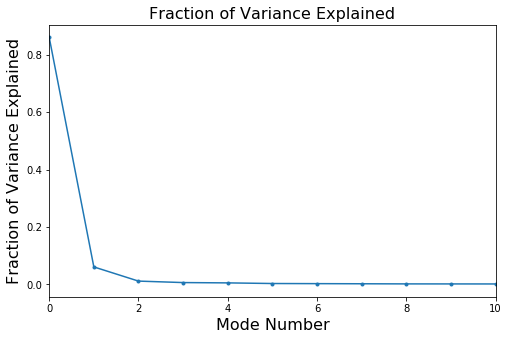

In [15]:
fig = plt.figure(figsize=(8,5))
plt.plot(np.arange(0,np.size(ds_eof['time'])),solver.varianceFraction().values,'.-')
solver.varianceFraction().values[0]+solver.varianceFraction().values[1]
plt.xlim([0,10])
plt.title('Fraction of Variance Explained',fontsize=16)
plt.xlabel('Mode Number',fontsize=16)
plt.ylabel('Fraction of Variance Explained',fontsize=16)

###### *Time Evolution of Major Modes*

In [25]:
climatology=pcs[:,0].groupby("time.month").mean("time")

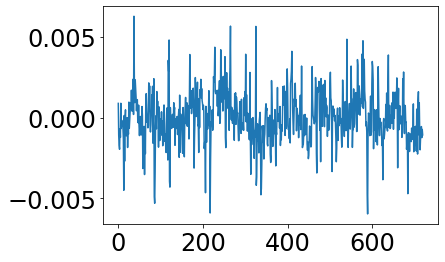

In [27]:
plt.plot(pcs[:,0].groupby('time.month')-climatology)

/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/glade/u/home/czarakas/.conda/envs/EOF_env/lib/python3.7/site-packages/ipykernel_launcher.py:29:

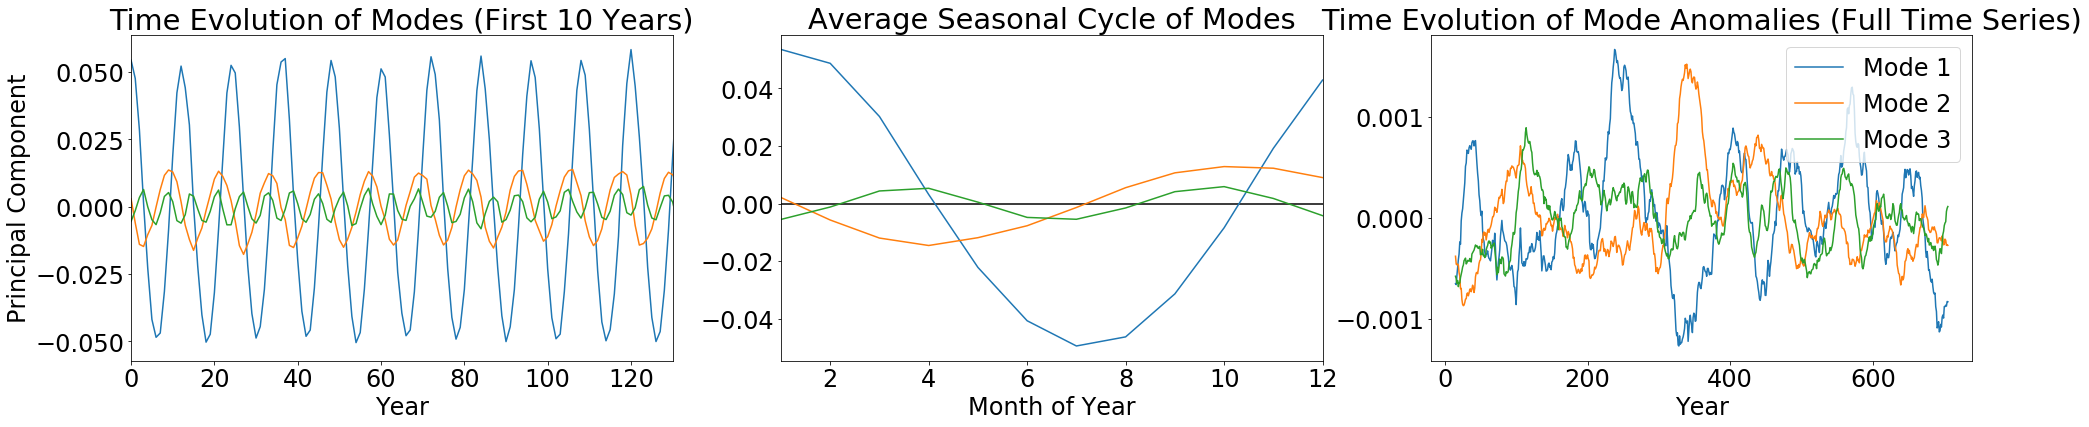

In [30]:
ntime=np.size(pcs['time'])
fig = plt.figure(figsize=(33,6))
matplotlib.rcParams.update({'font.size': 24})
for i in range(0,3):
    this_pc = pcs[:,i]
    climatology = this_pc.groupby("time.month").mean("time")
    anomalies = this_pc.groupby("time.month") - climatology
    anomalies = anomalies.load()
    anomalies = anomalies.rolling(time=30, center=True).mean()
    ax = plt.subplot(1, 3, 1)
    #if i==0:
    #    plt.plot([1850,1860],[0,0],'-k')
    plt.plot(this_pc.values,label='Mode '+str(i+1))
    plt.xlabel('Year')
    plt.ylabel('Principal Component')
    plt.title('Time Evolution of Modes (First 10 Years)')
    plt.xlim([0, 13*10])
    #plt.ylim([-0.03,0.03])
    
    ax = plt.subplot(1, 3, 2)
    if i==0:
        plt.plot([0,12],[0,0],'-k')
    plt.plot(np.arange(1,13),climatology,label='Mode '+str(i+1))
    plt.xlabel('Month of Year')
    plt.title('Average Seasonal Cycle of Modes')
    #plt.ylim([-0.03,0.03])
    plt.xlim([1,12])
    
    ax = plt.subplot(1, 3, 3)
    #if i==0:
    #    plt.plot([1850,2015],[0,0],'-k')
    plt.plot(anomalies,label='Mode '+str(i+1))
    plt.xlabel('Year')
    plt.title('Time Evolution of Mode Anomalies (Full Time Series)')
    #plt.xlim([1850,2015])
plt.legend()

###### *Spatial Pattern of Major Modes*

In [32]:
import quick_map

/glade/u/home/czarakas/coupled_PPE/code/analyze_simulations/quick_map.py:71: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
  cbar.set_clim(clim)


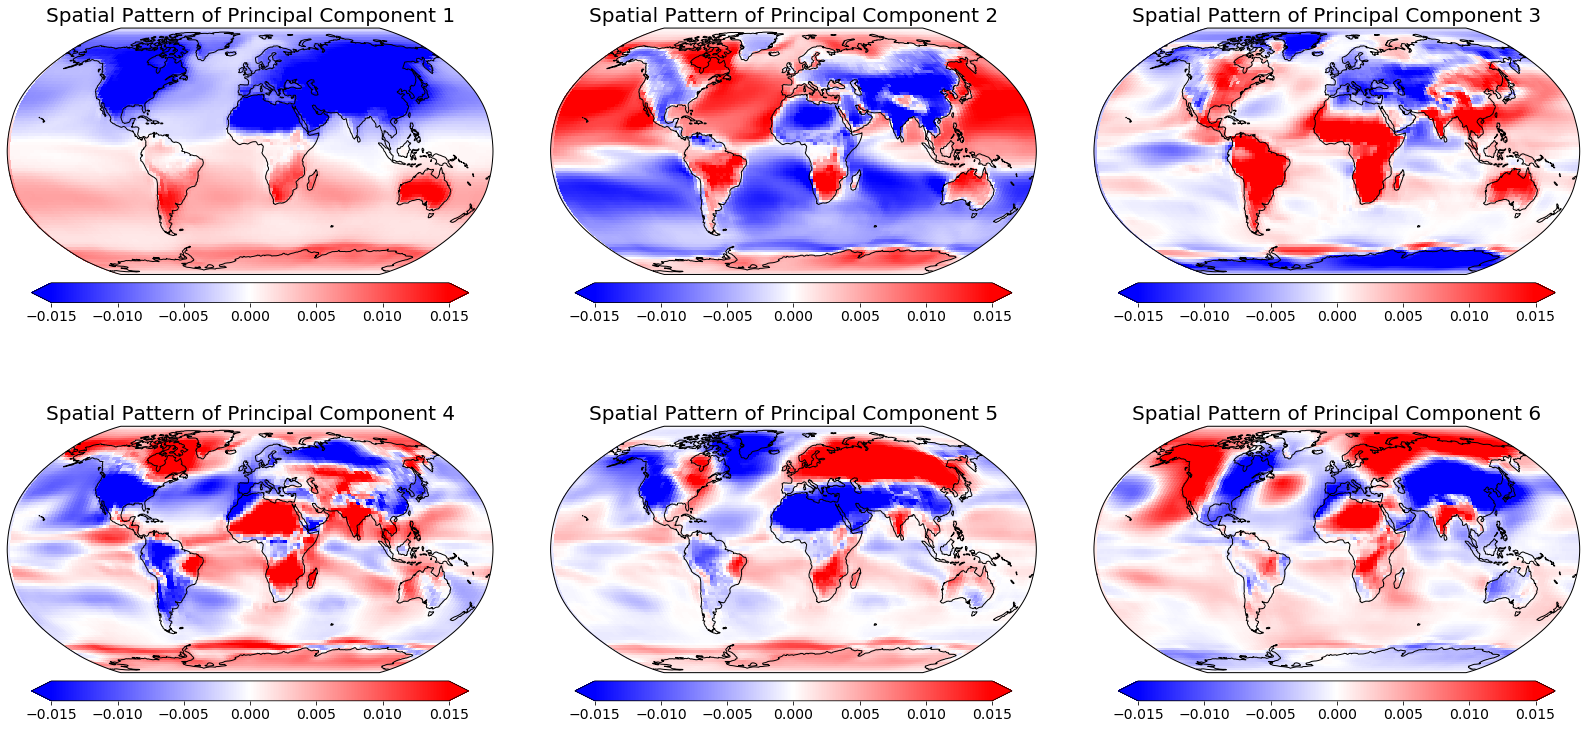

In [35]:
lats=eofs['lat'].values
lons = eofs['lon'].values
fig = plt.figure(figsize=(23, 12))
for i in range(0,6):
    quick_map.quick_map_subplot(np.transpose(eofs[:,:,i].values),lats,lons, nrow=2, ncol=3, ind=i,
                                clim=[-0.015,0.015],cmap=plt.cm.bwr,
                                title='Spatial Pattern of Principal Component '+str(i+1))
plt.tight_layout()

# PCA Analysis of Annual Averages of Data

In [42]:
#-------------------take annual average-------------------
ds_eof = ds_to_analyze.groupby('time.year').mean(dim='time')
ds_eof=ds_eof.rename({'year':'time'})
ds_eof = ds_eof - ds_eof.mean(dim='time')
ds_eof.load()

<xarray.DataArray 'TREFHT' (time: 140, lat: 96, lon: 144)>
array([[[-0.9130554 , -0.91293335, -0.9128876 , ..., -0.91316223,
         -0.913147  , -0.913147  ],
        [-0.7371826 , -0.7171936 , -0.7025299 , ..., -0.7891693 ,
         -0.7723541 , -0.75309753],
        [-0.8168335 , -0.7828369 , -0.7499237 , ..., -0.8852539 ,
         -0.868927  , -0.84788513],
        ...,
        [ 1.1337585 ,  1.1256714 ,  1.1213074 , ...,  1.1441345 ,
          1.1399841 ,  1.1369629 ],
        [ 0.9565735 ,  0.9416199 ,  0.9266968 , ...,  0.9961853 ,
          0.9831543 ,  0.97003174],
        [ 0.9041748 ,  0.90164185,  0.89746094, ...,  0.9227905 ,
          0.9145508 ,  0.90737915]],

       [[-0.59817505, -0.598053  , -0.5980377 , ..., -0.5983429 ,
         -0.59832764, -0.5982666 ],
        [-0.6979523 , -0.701004  , -0.70783997, ..., -0.69003296,
         -0.6937866 , -0.6996002 ],
        [-0.6500397 , -0.6585083 , -0.65911865, ..., -0.6143646 ,
         -0.6237793 , -0.63957214],
        ...,
        [ 0.39559937,  0.4178772 ,  0.43170166, ...,  0.27218628,
          0.31195068,  0.35562134],
        [ 0.07260132,  0.08773804,  0.09680176, ...,  0.01611328,
          0.03311157,  0.05236816],
        [ 0.09539795,  0.10275269,  0.11193848, ...,  0.08407593,
          0.08624268,  0.08963013]],

       [[ 0.7435608 ,  0.7437744 ,  0.7438202 , ...,  0.74339294,
          0.7434082 ,  0.74346924],
        [ 0.6153259 ,  0.604599  ,  0.5913391 , ...,  0.670578  ,
          0.6484375 ,  0.6277466 ],
        [ 0.6874237 ,  0.6538086 ,  0.61524963, ...,  0.7495117 ,
          0.7283325 ,  0.71559143],
        ...,
        [ 1.2010193 ,  1.2417908 ,  1.2756042 , ...,  1.093811  ,
          1.1228027 ,  1.1586914 ],
        [ 0.9081421 ,  0.92474365,  0.94000244, ...,  0.8531494 ,
          0.8717346 ,  0.89004517],
        [ 0.43588257,  0.42919922,  0.4225769 , ...,  0.4326477 ,
          0.4376526 ,  0.4393921 ]],

       ...,

       [[ 1.0341797 ,  1.0340729 ,  1.0340424 , ...,  1.0341339 ,
          1.0340881 ,  1.0341339 ],
        [ 0.9812012 ,  0.9754181 ,  0.9624176 , ...,  1.006485  ,
          0.9989319 ,  0.98960876],
        [ 0.90556335,  0.89012146,  0.87898254, ...,  0.91270447,
          0.91178894,  0.911911  ],
        ...,
        [ 0.7090759 ,  0.77001953,  0.8105774 , ...,  0.5420532 ,
          0.59661865,  0.64801025],
        [ 0.93878174,  0.96621704,  0.9967041 , ...,  0.87838745,
          0.89764404,  0.9168396 ],
        [ 1.0618896 ,  1.071167  ,  1.0828857 , ...,  1.0342102 ,
          1.0437622 ,  1.0534668 ]],

       [[ 0.85632324,  0.85672   ,  0.8568268 , ...,  0.85621643,
          0.8562012 ,  0.85627747],
        [ 0.813324  ,  0.81381226,  0.81185913, ...,  0.8073883 ,
          0.80926514,  0.80973816],
        [ 1.0195618 ,  1.0368042 ,  1.0430756 , ...,  0.97265625,
          0.9897766 ,  1.0014343 ],
        ...,
        [-0.16827393, -0.13272095, -0.09609985, ..., -0.21081543,
         -0.20266724, -0.19064331],
        [-0.28225708, -0.2699585 , -0.2548828 , ..., -0.30429077,
         -0.29907227, -0.2920227 ],
        [-0.35516357, -0.35620117, -0.35705566, ..., -0.35842896,
         -0.3562622 , -0.35473633]],

       [[ 0.8278351 ,  0.8282776 ,  0.8283539 , ...,  0.82774353,
          0.8277588 ,  0.8278351 ],
        [ 0.71525574,  0.7149811 ,  0.71206665, ...,  0.72006226,
          0.7163086 ,  0.7192383 ],
        [ 0.2810669 ,  0.28388977,  0.29077148, ...,  0.31462097,
          0.28848267,  0.28079224],
        ...,
        [-0.44137573, -0.45217896, -0.4482422 , ..., -0.41833496,
         -0.42404175, -0.4307251 ],
        [-0.55651855, -0.5613098 , -0.5662842 , ..., -0.55352783,
         -0.5529175 , -0.55355835],
        [-0.58761597, -0.58825684, -0.5888672 , ..., -0.5904236 ,
         -0.58865356, -0.5873413 ]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0

### Perform EOF

In [37]:
solver = Eof(ds_eof, weights=areaweights)
eofs = solver.eofs()
eofs = eofs.transpose()
pcs = solver.pcs()

Text(0, 0.5, 'Fraction of Variance Explained')

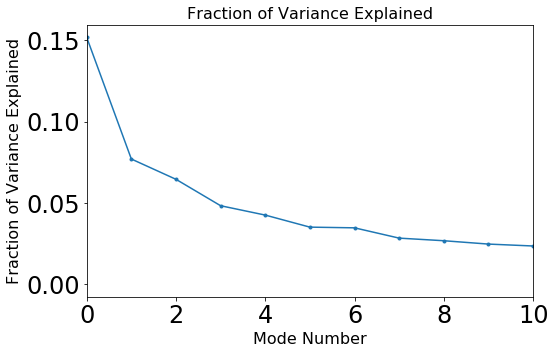

In [38]:
fig = plt.figure(figsize=(8,5))
plt.plot(np.arange(0,np.size(ds_eof['time'])),solver.varianceFraction().values,'.-')
solver.varianceFraction().values[0]+solver.varianceFraction().values[1]
plt.xlim([0,10])
plt.title('Fraction of Variance Explained', fontsize=16)
plt.xlabel('Mode Number', fontsize=16)
plt.ylabel('Fraction of Variance Explained', fontsize=16)

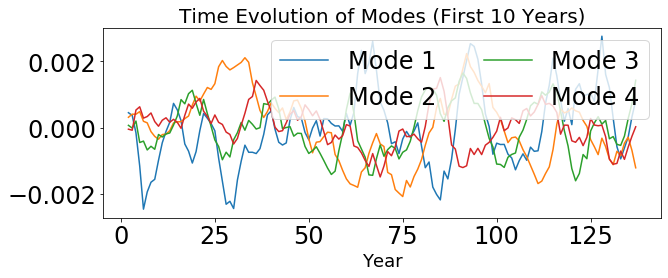

In [39]:
ntime=np.size(pcs['time'])
fig = plt.figure(figsize=(10,3.5))
#plt.plot([1850,2015],[0,0],'-k')
for i in range(0,4):
    this_pc = pcs[:,i]
    this_pc = this_pc.load()
    this_pc = this_pc.rolling(time=5, center=True).mean()
    plt.plot(this_pc.values,label='Mode '+str(i+1))
    plt.xlabel('Year', fontsize=18)
    #plt.ylabel('Principal Component', fontsize=18)
    #plt.xlim([1850,2015])
    plt.title('Time Evolution of Modes (First 10 Years)', fontsize=20)
    
plt.legend(ncol=2)

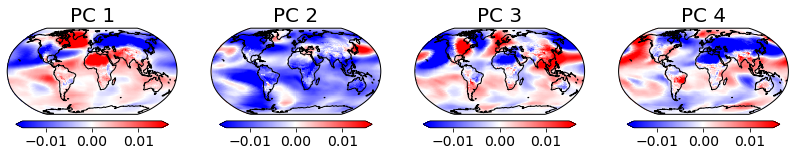

In [41]:
lats = eofs['lat'].values
lons = eofs['lon'].values
fig = plt.figure(figsize=(14, 6))
for i in range(0,4):
    quick_map.quick_map_subplot(np.transpose(eofs[:,:,i].values),lats,lons, nrow=1, ncol=4, ind=i,
                                clim=[-0.015,0.015],cmap=plt.cm.bwr,
                                title='PC '+str(i+1))
#fig.savefig(DATA_PATH+'figures/'+modelname+'_annual_major_modes'+'.png', dpi=300, facecolor=None, edgecolor=None,
#                    bbox_inches='tight', transparent=True, pad_inches=0.2, linewidth=2)

# Annual EOF for each ensemble simulation

In [53]:
modelnames = var_array.ensemble_key
solvers = []

area_weights = areaweights
for m, modelname in enumerate(crosswalk.Key_short.values):
    ds=ds_ensemble[m]

    annual_data = ds[var][60*12:,:,:].groupby('time.year').mean(dim='time')
    
    #-------------------take annual average-------------------
    #annual_data = ds.groupby('time.year').mean(dim='time')
    annual_data=annual_data.rename({'year':'time'})
    
    ds_eof = annual_data.load()
    
    #----------------- take eof------------------------------
    ds_eof = ds_eof - ds_eof.mean(dim='time')
    solver = Eof(ds_eof, weights=areaweights)
    solvers.append(solver)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


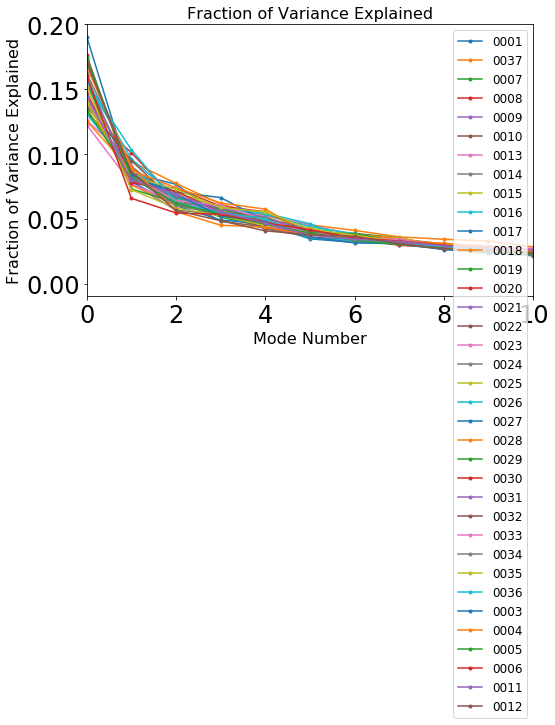

In [57]:
fig = plt.figure(figsize=(8,5))
for m, modelname in enumerate(modelnames):
    print(m)
    solver=solvers[m]
    plt.plot(np.arange(0,np.size(solver.varianceFraction().values)),
                 solver.varianceFraction().values,'.-',label=modelname.values)
plt.xlim([0,10])
plt.title('Fraction of Variance Explained', fontsize=16)
plt.xlabel('Mode Number', fontsize=16)
plt.ylabel('Fraction of Variance Explained', fontsize=16)
plt.legend(fontsize=12)

In [64]:
import make_multisimulation_dataset
var_array = make_multisimulation_dataset.make_empty_dataarray(ds_grid=ds_grid, var=var, keys=keys)

/glade/u/home/czarakas/coupled_PPE/code/analyze_simulations/quick_map.py:71: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
  cbar.set_clim(clim)


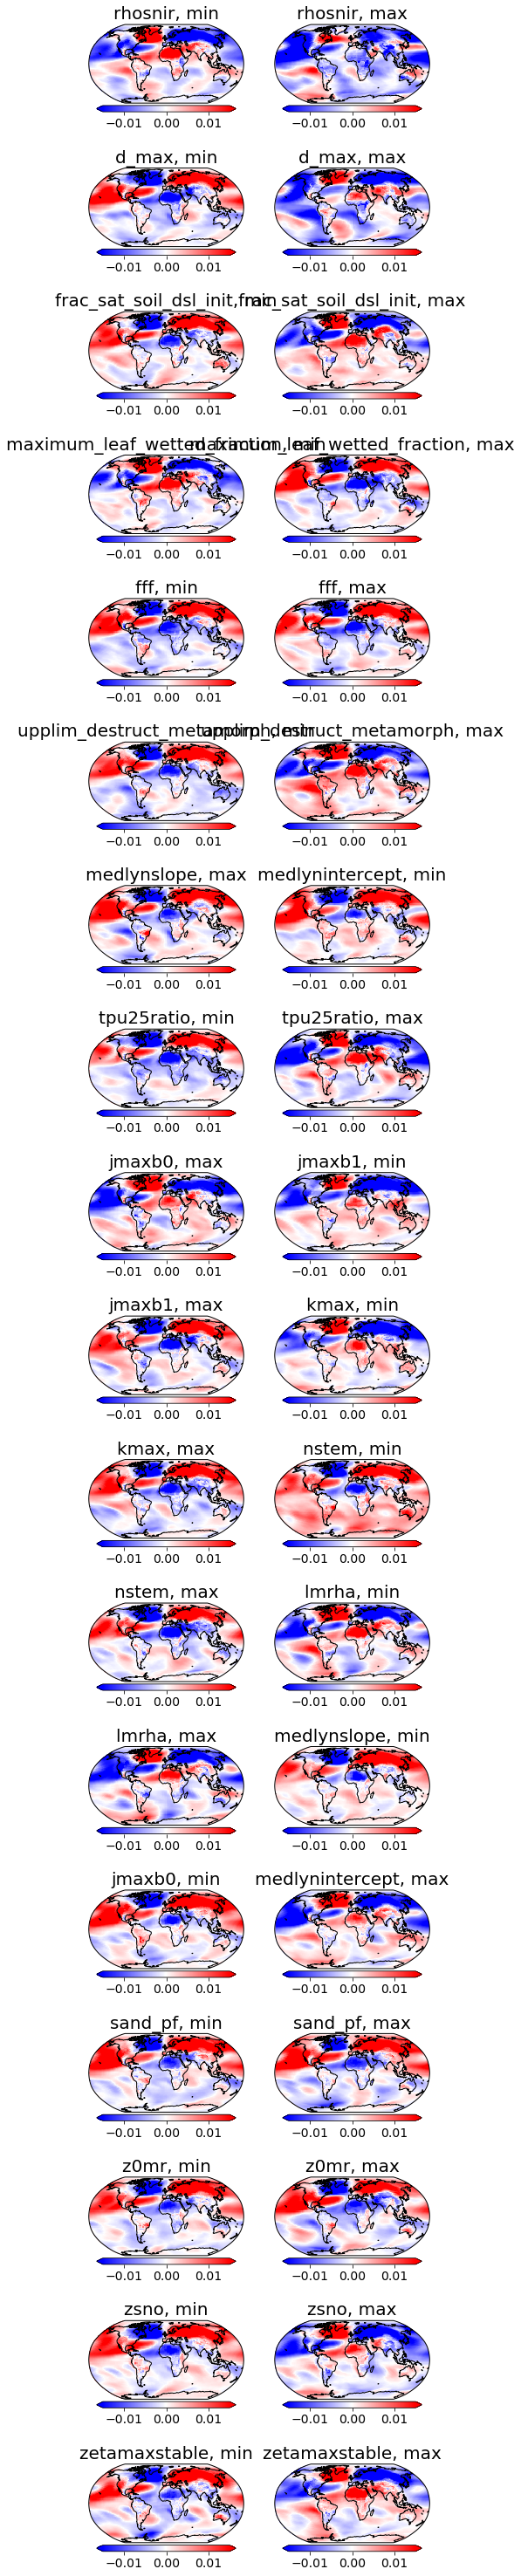

In [65]:
fig = plt.figure(figsize=(7, 3*20))
mode_num=0
for m, modelname in enumerate(crosswalk.description.values):
    solver=solvers[m]
    eofs = solver.eofs()
    eofs = eofs.transpose()
    lats = eofs['lat'].values
    lons = eofs['lon'].values
    
    var_array[:,:,m]=np.transpose(eofs[:,:,mode_num].values)
    
    quick_map.quick_map_subplot(np.transpose(eofs[:,:,mode_num].values),lats,lons,
                                nrow=20, ncol=2, ind=m,
                                clim=[-0.015,0.015],cmap=plt.cm.bwr,
                                title=modelname)

Text(0.5, 1.0, '')

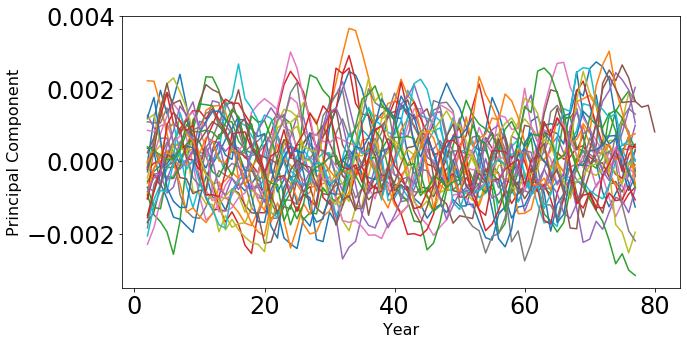

In [63]:
fig = plt.figure(figsize=(10, 5))
for m, modelname in enumerate(crosswalk.description.values):
    solver=solvers[m]
    pcs = solver.pcs()
    ntime=np.size(pcs['time'])
    this_pc = pcs[:,mode_num]
    this_pc = this_pc.load().rolling(time=5, center=True).mean()
    plt.plot(this_pc.values, label=modelname)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Principal Component', fontsize=16)
plt.title('')

# Now look at EOF across simulations of leading EOFs for each simulation

In [66]:
ds_eofs = var_array

# Rearrange all-model dataset for EOF
ds_eofs=ds_eofs.transpose()
ds_eofs=ds_eofs.rename({"ensemble_key": "time"})
ds_eofs['time']=np.arange('2000-01-01', '2000-02-06', dtype='datetime64') #11
ds_eofs=ds_eofs-ds_eofs.mean(dim='time')

solver = Eof(ds_eofs, weights=areaweights.transpose())
eofs = solver.eofs()
eofs = eofs.transpose()
pcs = solver.pcs()

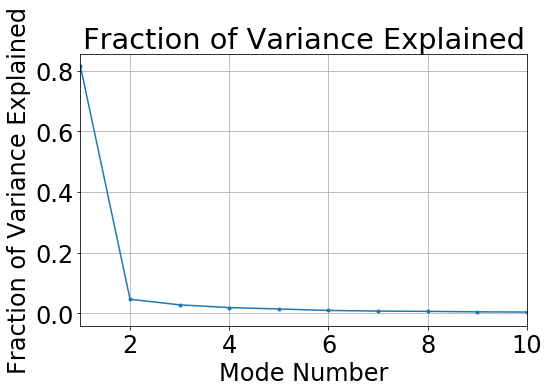

In [67]:
fig = plt.figure(figsize=(8,5))
plt.plot(np.arange(1,np.size(ds_eofs['time'])+1),solver.varianceFraction().values,'.-')
solver.varianceFraction().values[0]+solver.varianceFraction().values[1]
plt.xlim([1,10])
plt.title('Fraction of Variance Explained')
plt.xlabel('Mode Number')
plt.ylabel('Fraction of Variance Explained')
plt.grid()
plt.savefig(var+'_frac_variance_explained.png')

In [78]:
for i in np.arange(0,4):
    print('EOF '+str(i+1))
    print(solver.varianceFraction().values[i])
#print(solver.varianceFraction().values[0:2])

EOF 1
0.8139323846197153
EOF 2
0.04676062821042301
EOF 3
0.02829071096828339
EOF 4
0.01935612489290058


/glade/u/home/czarakas/coupled_PPE/code/analyze_simulations/quick_map.py:71: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
  cbar.set_clim(clim)


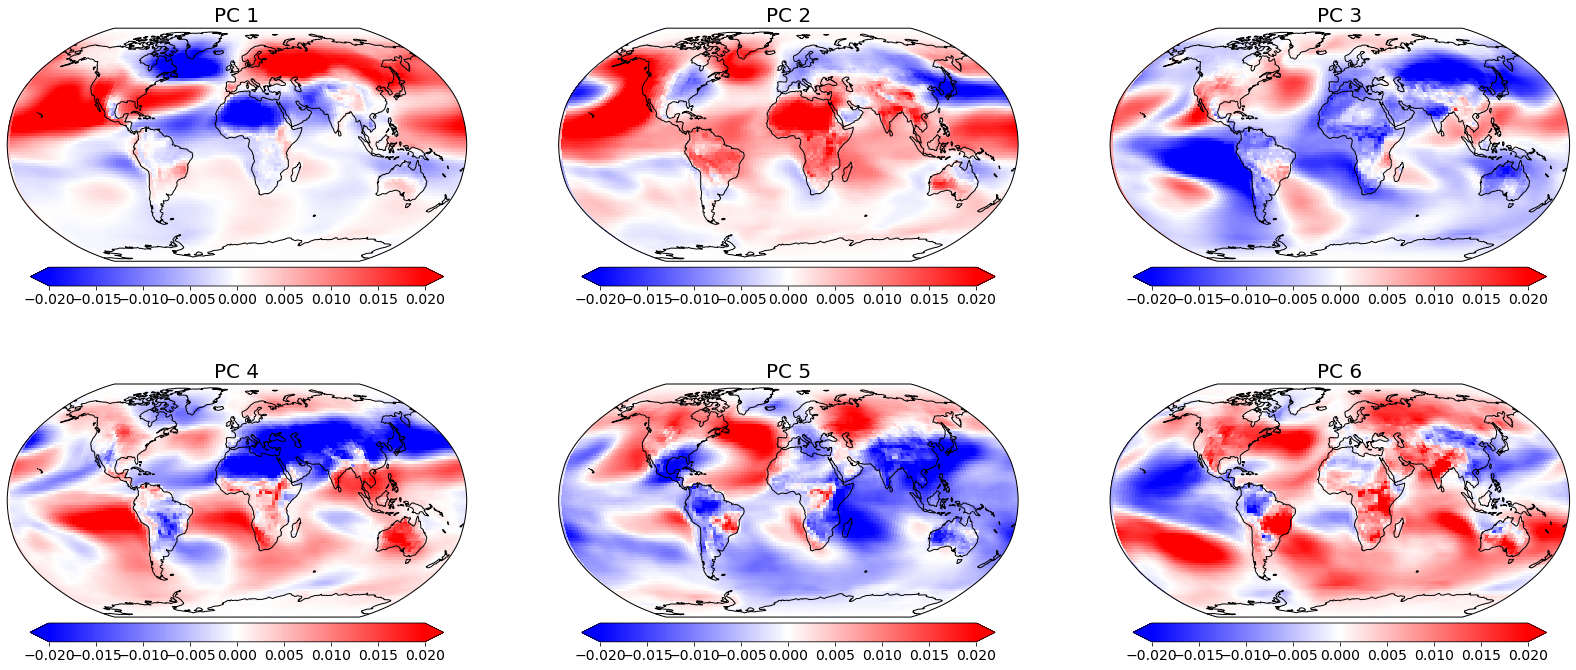

In [68]:
lats = eofs['lat'].values
lons = eofs['lon'].values
fig = plt.figure(figsize=(28, 12))
for i in range(0,6):
    quick_map.quick_map_subplot(eofs[:,:,i].values,lats,lons, nrow=2, ncol=3, ind=i,
                                clim=[-0.02,0.02],cmap=plt.cm.bwr,
                                title='PC '+str(i+1))
plt.savefig(var+'_EOFofEOFs_PCs.png')

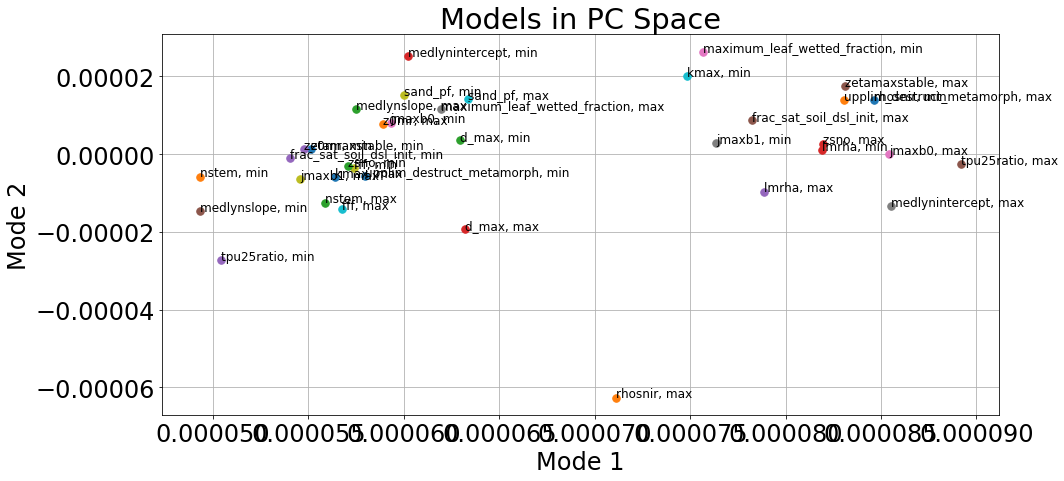

In [77]:
labels=crosswalk.description.values#var_array.ensemble_key.values

fig = plt.figure(figsize=(15, 7))
#plt.plot([-500,170],[0,0],'-k')
#plt.plot([0,0],[-175,150],'-k')
pc1 = pcs[:,0].values
pc2 = pcs[:,1].values
for m, modelname in enumerate(labels):
    plt.plot(np.abs(pc1[m]), pc2[m],marker='.',linewidth=0,markersize=15, label=modelname)
    plt.annotate(modelname, [np.abs(pc1[m]), pc2[m]], fontsize=12)
plt.xlabel('Mode 1')
plt.ylabel('Mode 2')
plt.title('Models in PC Space')
plt.grid()
#plt.legend(fontsize=12)
#plt.xlim([-100,150])
#plt.ylim([-20,70])
plt.savefig(var+'_PC1vsPC2_projection.png')